In [1]:
#Name: Vedant Paresh Shah
#NET ID: VXS200021
#Course: AI CS6364.002

# Question 4:

In [2]:
import torch
import torch.nn as nn
import numpy as np
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
TrainSize = 60000
TestSize = 10000
Rows = 28
Cols = 28

In [5]:
File_Train_Data = gzip.open('train-set-images.gz', 'r')
File_Train_Data.read(16)
Buffer_Train_Data = File_Train_Data.read(TrainSize * Rows * Cols)
Train_Data = np.frombuffer(Buffer_Train_Data, dtype=np.uint8).astype(np.int32)
Train_Data = Train_Data.reshape(TrainSize, 1, Rows, Cols)

File_Train_Labels = gzip.open('train-set-labels.gz', 'r')
File_Train_Labels.read(8)
Buffer_Train_Labels = File_Train_Labels.read(TrainSize)
Train_Labels = np.frombuffer(Buffer_Train_Labels, dtype=np.uint8).astype(np.int32)

File_Test_Data = gzip.open('test-set-images.gz', 'r')
File_Test_Data.read(16)
Buffer_Test_Data = File_Test_Data.read(TestSize * Rows * Cols)
Test_Data = np.frombuffer(Buffer_Test_Data, dtype=np.uint8).astype(np.float32)
Test_Data = Test_Data.reshape(TestSize, 1, Rows, Cols)

File_Test_Labels = gzip.open('test-set-labels.gz', 'r')
File_Test_Labels.read(8)
Buffer_Test_Labels = File_Test_Labels.read(TestSize)
Test_Labels = np.frombuffer(Buffer_Test_Labels, dtype=np.uint8).astype(np.int32)

In [6]:
training_data, validating_data, training_labels, validating_labels = train_test_split(Train_Data, Train_Labels, test_size=0.1)

In [7]:
training_data = torch.Tensor(training_data)
training_labels = torch.Tensor(training_labels)

In [8]:
validating_data = torch.Tensor(validating_data)
validating_labels = torch.Tensor(validating_labels)

In [9]:
testing_data = torch.Tensor(Test_Data)
testing_labels = torch.Tensor(Test_Labels)

In [10]:
train = torch.utils.data.TensorDataset(training_data, training_labels)
test = torch.utils.data.TensorDataset(testing_data, testing_labels)
valid = torch.utils.data.TensorDataset(validating_data, validating_labels)

In [11]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=128)

Image visualization: 


IndexError: index 3 is out of bounds for axis 0 with size 3

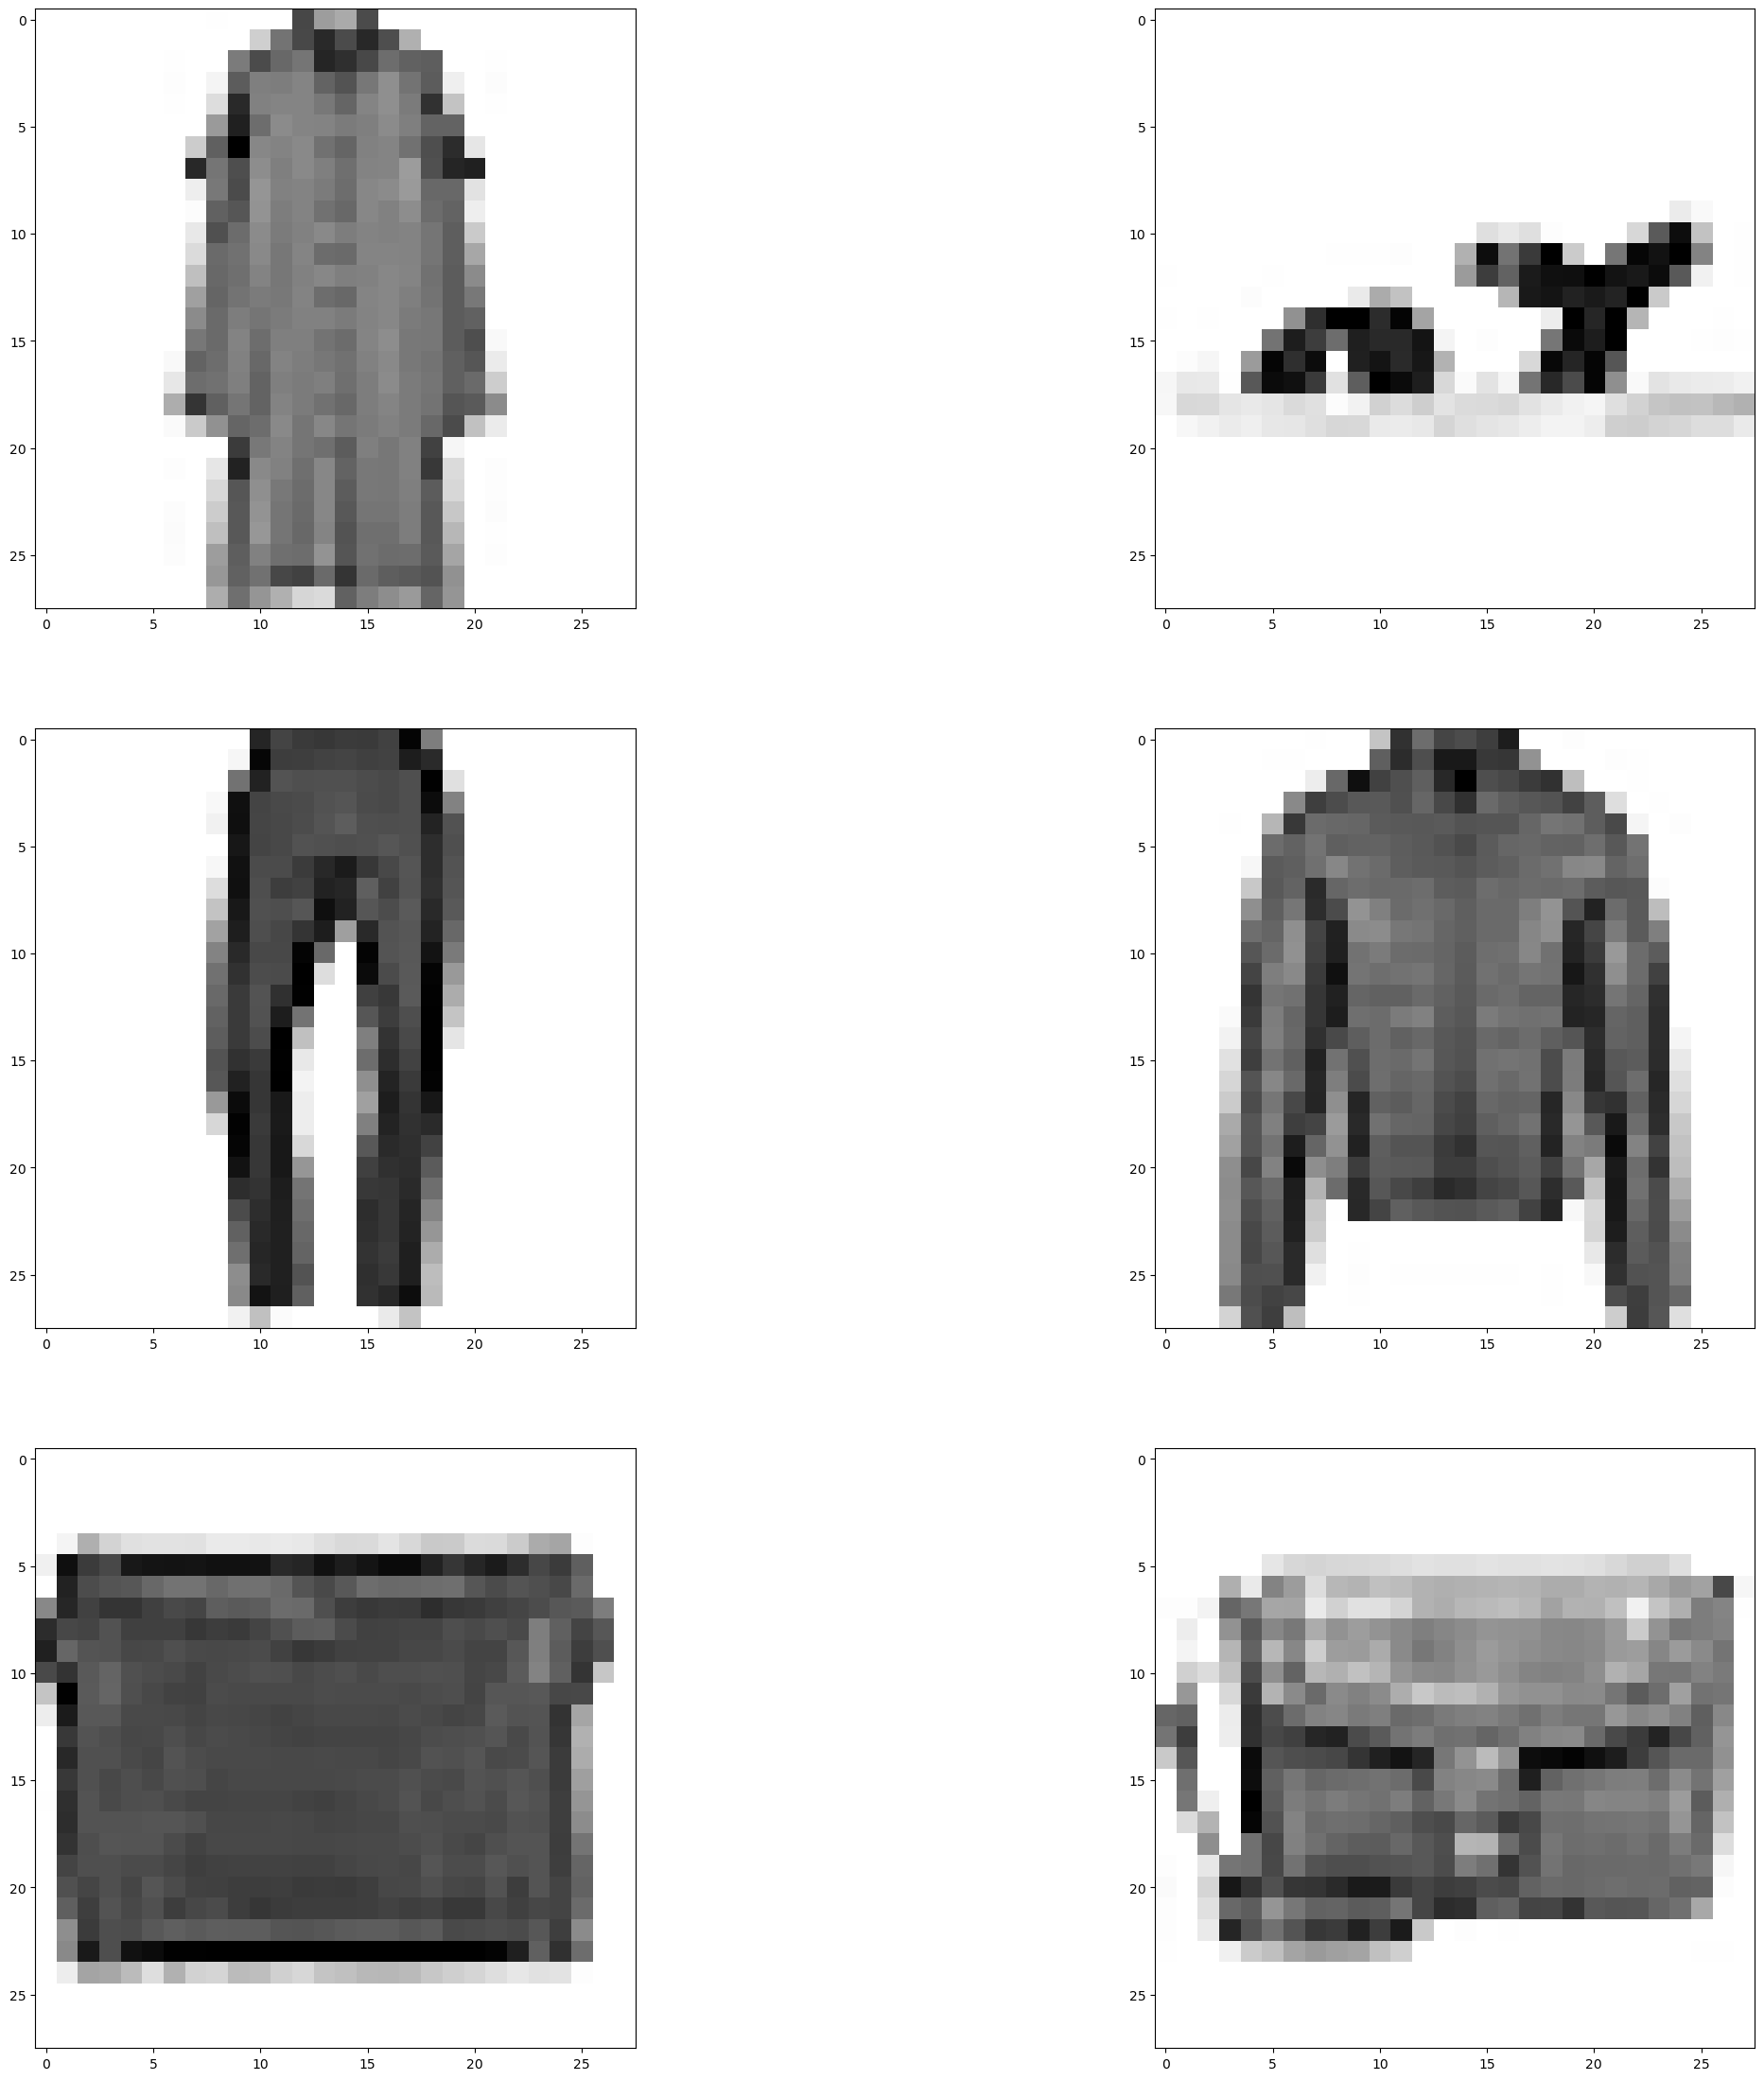

In [17]:
print('Image visualization: ')
fig, ax = plt.subplots(3, 2, figsize=(Rows, Cols))
for i in range(16):
    img = training_data[i, :, :, :].reshape((Rows, Cols))
    row = i // 3
    col = i % 2
    ax[row][col].imshow(img, cmap='Greys')
plt.show()

In [302]:
class Model(nn.Module):
    def __init__(self, OutFeatures):
        super(Model, self).__init__()

        self.layers_1 = nn.ModuleList([
            nn.Conv2d(1, 4, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(4,4, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        ])

        self.layers_2 = nn.ModuleList([
            nn.Flatten(),
            nn.Linear(196, OutFeatures),
            nn.Softmax(dim=1)
        ])

    def forward(self, x):
        out = x
        for layer in self.layers_1:
            out = layer(out)
        for layer in self.layers_2:
            out = layer(out)
        return out

In [303]:
def train_model(model, optimizer, criterion, device, train_loader, test_loader, valid_loader, epochs):
    model = model.to(device)
    training_losses = []
    validation_losses = []
    for epoch in range(epochs):
        training_loss = 0
        n = 0
        tq = tqdm(train_loader)
        tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch, 0))
        model.train()
        for i, data in enumerate(tq):
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)

            outputs = model(batch)
            optimizer.zero_grad()
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            training_loss += loss.item() * len(batch)
            n += len(batch)
            tq.set_description('Epoch {0:d}, Average Train Loss: {1:5.6f}'.format(epoch,training_loss / n,))
        training_losses.append(training_loss / n)
        
        model.eval()
        training_length = 0
        training_correct = 0
        training_loss = 0
        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels.long())
            training_loss += loss.item() * len(batch)
            training_length += len(labels)
            training_correct += (predicted == labels).sum().item()

        validation_loss = 0
        validation_length = 0
        validation_correct = 0
        model.eval()
        for batch, labels in valid_loader:
            batch, labels = batch.to(device), labels.to(device)
            outputs = model(batch)
            loss = criterion(outputs, labels.long())
            validation_loss += loss.item() * len(batch)
            _, predicted = torch.max(outputs.data, 1)
            validation_length += len(labels)
            validation_correct += (predicted == labels).sum().item()
        valid_losses.append(validation_loss / validation_length)
        time.sleep(0.1)
    print('Valid Accuracy: ', validation_correct / validation_length * 100)
    print('Train Accuracy: ', training_correct / training_length * 100)

    testing_predictions = []
    for batch, labels in test_loader:
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        _, predicted = torch.max(outputs.data, 1)
        testing_predictions += list(predicted.data.numpy())
    return training_losses, validation_losses, testing_predictions


In [304]:
OutFeatures = 10
model = Model(OutFeatures)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
training_losses, validation_losses, testing_predictions = train_model(model, optimizer, criterion, device, train_loader, test_loader, valid_loader, epochs = 25)
print('Test Accuracy: ', np.sum(np.array(test_predictions) == test_labels.numpy()) / len(test_predictions) * 100)


Epoch 24, Average Train Loss: 1.567492: 100%|█| 422/422 [00:06<00:00, 62.80it/s]


Valid Accuracy:  87.9
Train Accuracy:  89.17222222222222
Test Accuracy:  87.8


ValueError: x and y must have same first dimension, but have shapes (25,) and (0,)

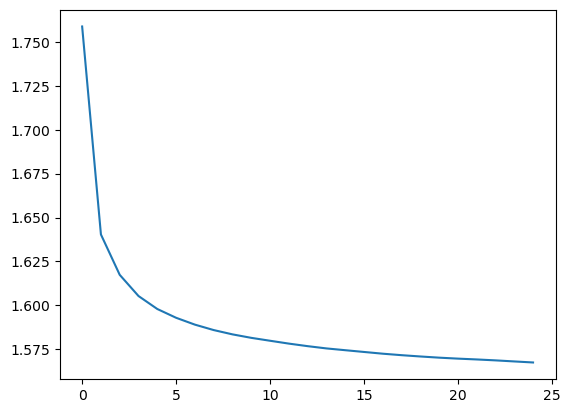

In [305]:
epochs_list = list(range(25))
plt.plot(epochs_list, training_losses, label='Training Loss')
plt.plot(epochs_list, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss (Cross Entropy)')
plt.legend()
plt.show()

In [ ]:
print('Image visualization: ')
fig, ax = plt.subplots(4, 4, figsize=(Rows, Cols))
for i in range(16):
    img = test_data[i, :, :, :].reshape((Rows, Cols))
    row = i // 4
    col = i % 4
    ax[row][col].imshow(img, cmap='Greys')
plt.show()